In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 80
batch_size = 100
learning_rate = 0.001

In [3]:
transform = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor()
    ])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True, 
                                             transform=transform,
                                             download=False)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False, 
                                            transform=transforms.ToTensor())
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
example = enumerate(train_loader)
i,(image,label) = next(example)
print(image.size())
print(label.size())

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [4]:
def conv3x3(in_channels, out_channels, stride=1):
    """
    3x3的same卷积(s=1时)
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                      stride=stride, padding=1, bias=False)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        describe:
            Residual block(低层的残差块)，x = F(x) + x
        input:
            in_channels: 输入的channels数
            out_channels: 输出channels数
            stride: 步长，默认1
            downsample: 是否下采样（相加的两个量维度是否相等）
        """
        super(ResidualBlock, self).__init__()
        # 疑惑：为啥这里有stride，conv2没加，不都是stride=1吗
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 将得到的值计算得到的值覆盖之前的值
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        """
        describe:
            x -> residual
            x -> conv1 -> bn1 -> relu -> conv2 -> bn2
            将上述两个叠加后（看是否维度一致：downsample=？）-> out
            out -> relu -> 输出
        """
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self .conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out   

resblock = ResidualBlock(16, 32)
print(resblock)

ResidualBlock(
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [6]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        """
        input:
            block: 这里是ResidualBlock
            layers: 一个一维list，存放每个layer对应的block数目，
            如[2, 2, 2]对应ResNet18（不完全），layer1,2,3都有2个block
            num_classes: 10类别(CIFAR10)
            
        """
        super(ResNet, self).__init__()
        self.in_channels = 16   # 输入到layer1的channel数为16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, out_channels=16, blocks=layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        """
        input:
            block: 这里是ResidualBlock
            out_channels: 输出的通道数
            blocks: 当前layer的block数目，如layer2对应2
            stride: 默认步长1
        """
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            # 此种情况维度出现不一致, 通过3x3conv使得输入输出维度一致
            # 以layer2为例：(stride=2)!=1且(in=16) != (out=32)
            # 设置downsample为3x3的conv, stride=2, in=16, out=32
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []    # 定义layers 列表
        # 列表中添加res block (16x32x32 -> 32x16x16)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        # 更新in_channels值，将本次out_channels作为下次的in_channels
        self.in_channels = out_channels
        # 注意这里下标从1开始，以layer2举例，
        # 这个for只append了一个res block（32x16x16 -> 32x16x16）
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        describe:
            x(100,3,32,32) -> conv(100,16,32,32) -> bn -> relu -> 
            layer1(100,16,32,32) -> layer2(100,32,16,16) -> layer3(100,64,8,8) -> 
            avg_pool(100,64,1,1) -> resize(100,64) -> fc(100,10) -> 输出
        """
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [9]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

NameError: name 'model' is not defined

In [31]:
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epoches):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%100 == 0:
            print("Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}".format(
                epoch+1, num_epoches, i+1, total_step, loss.item()))
    
    if (epoch+1)%20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch: [1/5], Step: [100/500], Loss: 1.5668
Epoch: [1/5], Step: [200/500], Loss: 1.2881
Epoch: [1/5], Step: [300/500], Loss: 1.3484
Epoch: [1/5], Step: [400/500], Loss: 1.2415
Epoch: [1/5], Step: [500/500], Loss: 1.0630
Epoch: [2/5], Step: [100/500], Loss: 1.2061
Epoch: [2/5], Step: [200/500], Loss: 1.0709
Epoch: [2/5], Step: [300/500], Loss: 0.9323
Epoch: [2/5], Step: [400/500], Loss: 0.7828
Epoch: [2/5], Step: [500/500], Loss: 1.0241
Epoch: [3/5], Step: [100/500], Loss: 1.0637
Epoch: [3/5], Step: [200/500], Loss: 1.0324
Epoch: [3/5], Step: [300/500], Loss: 0.8380
Epoch: [3/5], Step: [400/500], Loss: 0.6729
Epoch: [3/5], Step: [500/500], Loss: 0.7945
Epoch: [4/5], Step: [100/500], Loss: 0.8276
Epoch: [4/5], Step: [200/500], Loss: 0.7589
Epoch: [4/5], Step: [300/500], Loss: 0.7063
Epoch: [4/5], Step: [400/500], Loss: 0.7683
Epoch: [4/5], Step: [500/500], Loss: 0.9856
Epoch: [5/5], Step: [100/500], Loss: 0.5390
Epoch: [5/5], Step: [200/500], Loss: 0.6316
Epoch: [5/5], Step: [300/500], L

In [11]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on the test images: {}%'.format(100*correct/total))

Accuracy of the model on the test images: 68.24%


In [33]:
torch.save(model.state_dict(), 'resnet18.ckpt')

In [24]:
model.load_state_dict(torch.load('resnet18.ckpt'))

In [ ]:
import matplotlib.pyplot as plt
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

test_example = enumerate(test_loader)
_, (images, labels) = next(test_example)
images = images.to(device)
labels = labels.to(device)
    
print(images.size())
plt.imshow(images[1].permute(1,2,0))    # (3x32x32 -> 32x32x3)
plt.show()
print('label: {}'.format(classes[labels[1]]))
    
output = model(images)
_, predicted = torch.max(outputs.data, 1)
print('predicted: {}'.format(classes[predicted[0]]))

torch.Size([100, 3, 32, 32])


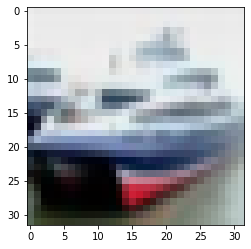

label: ship
predicted: ship
